# Importing Packages

In [7]:
import pandas as pd
pd.set_option('float_format', '{:f}'.format)
from sklearn.model_selection import train_test_split

%cd grape/

# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

# !pip3 install deap==1.3 

from ponyge2_adapted_files import Grammar, ge
from functions import div, plog, psqrt, exp
from functions import add, sub, mul, pdiv, neg, and_, or_, not_, less_than_or_equal, greater_than_or_equal
import algorithms

from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from deap import creator, base, tools
import seaborn as sns

# Defining Methods

In [ ]:
def import_data(): 

  # import data from GitHub 
  ratings_1_2 = pd.read_csv('https://raw.githubusercontent.com/nchichilidze/RS-with-GE/main/data/ratings/data/ratings_1_2.csv')
  ratings_3_5 = pd.read_csv('https://raw.githubusercontent.com/nchichilidze/RS-with-GE/main/data/ratings/data/ratings_3_5.csv')
  ratings_6_9 = pd.read_csv('https://raw.githubusercontent.com/nchichilidze/RS-with-GE/main/data/ratings/data/ratings_6_9.csv')
  ratings_10_13 = pd.read_csv('https://raw.githubusercontent.com/nchichilidze/RS-with-GE/main/data/ratings/data/ratings_10_13.csv')
  ratings_14_19 = pd.read_csv('https://raw.githubusercontent.com/nchichilidze/RS-with-GE/main/data/ratings/data/ratings_14_19.csv')

  # put the split data together
  ratings = ratings_1_2.copy(deep='True')

  for col in ratings_3_5.columns: 
    ratings[col] = ratings_3_5[col]

  for col in ratings_6_9.columns: 
    ratings[col] = ratings_6_9[col]

  for col in ratings_10_13.columns: 
    ratings[col] = ratings_10_13[col]

  for col in ratings_14_19.columns: 
    ratings[col] = ratings_14_19[col]

  # cast the features 

  y_col_name = 'rating'

  for column in ratings.columns: 
    ratings = ratings.astype({column: 'float'})

  ratings = ratings.astype({y_col_name: 'int'})

  ratings.dtypes

  # drop unnecessary columns 

  ratings = ratings.drop(columns=['user_id', 'movie_id'])

  # rename columns to match GE notation 

  columns = ['CBF', 'CF', 'is_favourite_genre',
       'ML_rating', 'ML_votes', 'age_at_rating', 'age_at_release',
       'born_before', 'gender', 'imdb_rating', 'imdb_votes', 'is_adult',
       'runtime_minutes', 'is_english', 'budget', 'popularity', 'TMDB_rating',
       'TMDB_votes', 'revenue'] 

  index = 1
  for col in columns: 
    new_name = 'x' + str(index)
    ratings = ratings.rename(columns={col: 'x' + str(index)})
    print(col + ' : ' + new_name)
    index += 1

  ratings = ratings.rename(columns={'rating': 'y'})


  # scale data [-1, 1]

  cols = list(set(ratings.columns) - set(['y'])) 

  for col in cols:
    ratings[col]=(ratings[col]-ratings[col].min())/(ratings[col].max()-ratings[col].min())
    
  ratings.describe()

  # rearrange columns 

  ratings = ratings[[ 'x1',	'x2',	'x3',	'x4'	,'x5',	'x6',	'x7',	'x8',	'x9',	'x10',	'x11',	'x12',	'x13'	,'x14',	'x15'	,'x16',	'x17',	'x18', 'x19', 'y']]
  ratings.head()


In [ ]:
def split_data(data):
    data_train, data_test = train_test_split(data, test_size = 0.2)

    print('train ' + str(data_train.shape))
    print('test ' + str(data_test.shape))
    
    train_rows = len(data_train)
    test_rows = len(data_test)

    cols = len(data_train.columns)
    
    X_train = np.zeros([cols, train_rows], dtype=float)
    Y_train = np.zeros([train_rows, ], dtype = float)

    for i in range(cols-1): 
        for j in range(train_rows): 
            X_train[i,j] = data_train['x' + str(i+1)].iloc[j]
  
    for i in range(train_rows):
        Y_train[i] = data_train['y'].iloc[i]
    
    
    X_test = np.zeros([cols, test_rows], dtype=float)
    Y_test = np.zeros([test_rows, ], dtype=float)

    for i in range(cols-1): 
        for j in range(test_rows): 
            X_test[i,j] = data_test['x' + str(i+1)].iloc[j]
  
    for i in range(test_rows):
        Y_test[i] = data_test['y'].iloc[i]
        
    return X_train, X_test, Y_train, Y_test

In [ ]:
def execute_grammatical_evolution(X_train, X_test, Y_train, Y_test):
    
    print("* setting up grammar ")
    # *************************** set up grammar ***************************
    GRAMMAR_FILE = 'rs-grammar-5.bnf'
    f = open("grammars/" + GRAMMAR_FILE, "r")
    # print(f.read())
    # f.close() 

    BNF_GRAMMAR = Grammar(path.join("grammars", GRAMMAR_FILE))
    
    # *************************** define variables ***************************
    POPULATION_SIZE = 1000
    MAX_GENERATIONS = 300
    P_CROSSOVER = 1
    P_MUTATION = 0.5
    ELITE_SIZE = round(0.01*POPULATION_SIZE)

    HALL_OF_FAME_SIZE = 1
    MAX_INIT_TREE_DEPTH = 10
    MIN_INIT_TREE_DEPTH = 1
    MAX_TREE_DEPTH = 17
    MAX_WRAPS = 0
    CODON_SIZE = 225
    
    # *************************** set up GE toolbox ***************************
    
    toolbox = base.Toolbox()

    # define a single objective, minimising fitness strategy:
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

    creator.create('Individual', ge.Individual, fitness=creator.FitnessMin)

    toolbox.register("populationCreator", ge.initialisation_PI_Grow, creator.Individual) 

    toolbox.register("evaluate", fitness_eval)

    # Tournament selection:
    toolbox.register("select", ge.selTournament, tournsize=7)

    # Single-point crossover:
    toolbox.register("mate", ge.crossover_onepoint)

    # Flip-int mutation:
    toolbox.register("mutate", ge.mutation_int_flip_per_codon)

    # *************************** perform grammatical evolution ***************************
    
    # create initial population (generation 0):
    population = toolbox.populationCreator(size=POPULATION_SIZE, 
                                    bnf_grammar=BNF_GRAMMAR, 
                                    min_init_tree_depth=MIN_INIT_TREE_DEPTH,
                                    max_init_tree_depth=MAX_INIT_TREE_DEPTH,
                                    max_tree_depth=MAX_TREE_DEPTH, 
                                    max_wraps=MAX_WRAPS,
                                    codon_size=CODON_SIZE
                                    )

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    import math 
    # prepare the statistics object:

    stats = tools.Statistics(key=lambda ind: ind.fitness.values)# if not ind.invalid else (np.NaN,))#ind.fitness.values != np.inf else None)
    stats.register("avg", np.nanmean)
    stats.register("std", np.nanstd)
    stats.register("min", np.nanmin)
    stats.register("max", np.nanmax)

    # perform the Grammatical Evolution flow:
    population, logbook = algorithms.ge_eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                        ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                        bnf_grammar=BNF_GRAMMAR, codon_size=CODON_SIZE, 
                                        max_tree_depth=MAX_TREE_DEPTH, max_wraps=MAX_WRAPS,
                                        points_train=[X_train, Y_train], 
                                        points_test=[X_test, Y_test], 
                                        stats=stats, halloffame=hof, verbose=False)
    
    
    # *************************** statistics ***************************
    print("* preparing results ")
    max_fitness_values, mean_fitness_values = logbook.select("max", "avg")
    min_fitness_values, std_fitness_values = logbook.select("min", "std")
    fitness_test = logbook.select("fitness_test")
    best_ind_length = logbook.select("best_ind_length")
    avg_length = logbook.select("avg_length")
    max_length = logbook.select("max_length")
    selection_time = logbook.select("selection_time")
    generation_time = logbook.select("generation_time")
    gen, invalid = logbook.select("gen", "invalid")

    # header = ['gen', 'invalid', 'avg', 'std', 'min', 'max', 'fitness_test', 'best_ind_length', 'avg_length', 'max_length', 'selection_time', 'generation_time']

    # results = pd.DataFrame(list(zip(gen, invalid, mean_fitness_values, std_fitness_values, min_fitness_values, max_fitness_values, fitness_test, best_ind_length, avg_length, max_length, selection_time, generation_time)),
    #            columns = header)

    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 10000)
    pd.set_option('display.colheader_justify', 'center')
    
    import textwrap
    best = hof.items[0].phenotype
    print("Best individual: \n","\n".join(textwrap.wrap(best,80)))
    print("\nTraining Fitness: ", hof.items[0].fitness.values[0])
    print("Test Fitness: ", fitness_eval(hof.items[0], [X_test,Y_test])[0])
    print("Depth: ", hof.items[0].depth)
    print("Length of the genome: ", len(hof.items[0].genome))
    print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')
    
    # *************************** plots ***************************

    # Extract statistics to plot graphs:

    collaborative_filtering = [] 
    for i in range(len(min_fitness_values)): 
        collaborative_filtering.append(0.86)

    plt.plot(gen, min_fitness_values, color='red', label="Training fitness")
    plt.plot(gen, fitness_test, color='blue', label="Test fitness")
    plt.plot(gen, collaborative_filtering , color='yellow', label="Collaborative Filtering Fitness")
    plt.legend(fontsize=12)
    plt.xlabel('Generations', fontsize=14)
    plt.ylabel('Best Fitness', fontsize=14)
    plt.title('Best Fitness over Generations', fontsize=16)
    plt.show()
    
    
    plt.plot(gen, max_length, color='red', label="Maximum")
    plt.plot(gen, avg_length, color='blue', label="Average")
    plt.plot(gen, best_ind_length, color='green', label="Best individual")
    plt.legend(fontsize=12)
    plt.xlabel('Generations', fontsize=14)
    plt.ylabel('Genome Length', fontsize=14)
    plt.title('Genome Length over Generations', fontsize=16)
    plt.show()

    # return results;

In [ ]:
def fitness_eval(individual, points):
    x = points[0]
    y = points[1]

    if individual.invalid == True:
        return np.NaN,

    try:
        pred = eval(individual.phenotype)
    except (FloatingPointError, ZeroDivisionError, OverflowError,
            MemoryError, ValueError):
        return np.NaN,
    assert np.isrealobj(pred)
    
    try:
        fitness = np.sqrt(np.mean((pred-y)**2))
    except (FloatingPointError, ZeroDivisionError, OverflowError,
            MemoryError, ValueError):
        fitness = np.NaN
    if fitness == float("inf"):
      return np.NaN,    
    return fitness,

# Experiments

## Experiments 1 - 3

experiment 1
*** splitting data 
train (800167, 20)
test (200042, 20)
*** finished splitting data 
*** grammatical evolution 
* setting up grammar 
* preparing results 
Best individual: 
 add(x[9],sub(add(x[6],mul(x[1],05.05)),x[1]))

Training Fitness:  0.7541071903026031
Test Fitness:  0.754487240913013
Depth:  7
Length of the genome:  32
Used portion of the genome: 0.41


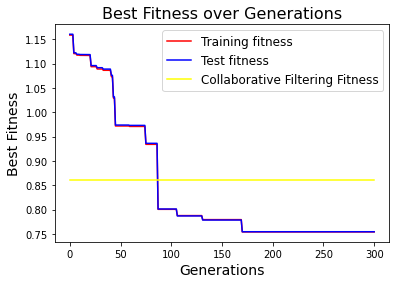

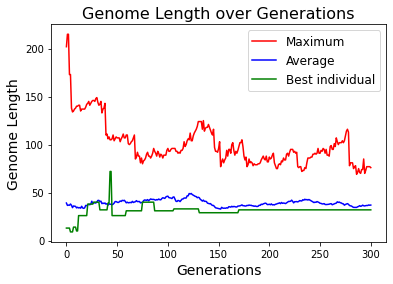

experiment 2
*** splitting data 
train (800167, 20)
test (200042, 20)
*** finished splitting data 
*** grammatical evolution 
* setting up grammar 
* preparing results 
Best individual: 
 add(x[1],sub(add(add(x[1],add(x[3],x[6])),x[1]),sub(x[0],x[13])))

Training Fitness:  0.8173457007654927
Test Fitness:  0.8136136892586403
Depth:  7
Length of the genome:  33
Used portion of the genome: 0.39


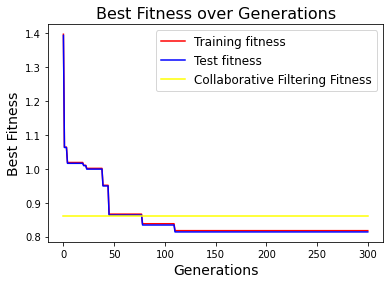

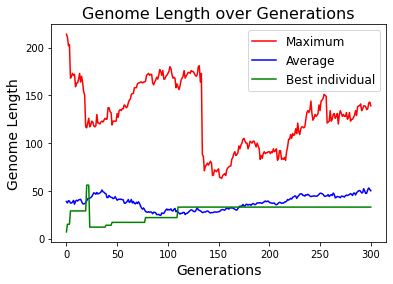

experiment 3
*** splitting data 
train (800167, 20)
test (200042, 20)
*** finished splitting data 
*** grammatical evolution 
* setting up grammar 
* preparing results 
Best individual: 
 add(sub(x[6],x[10]),add(x[12],mul(05.14,x[1])))

Training Fitness:  0.7730956659214884
Test Fitness:  0.7722151644230701
Depth:  6
Length of the genome:  43
Used portion of the genome: 0.30


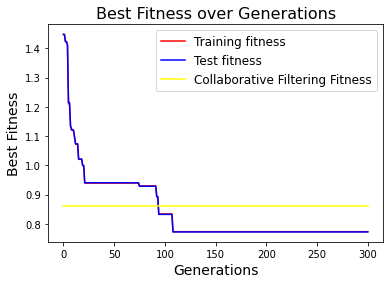

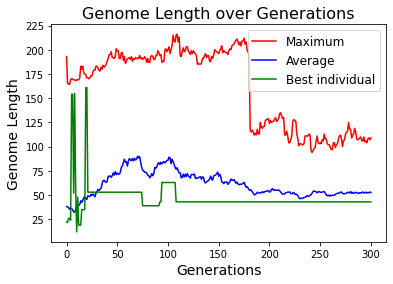

In [ ]:
results = []
for i in range(3): 
    print("experiment " + str(i+1))
    data = ratings.copy(deep=True)
    print("*** splitting data ")
    X_train, X_test, Y_train, Y_test = split_data(data)
    print("*** finished splitting data ")
    print("*** grammatical evolution ")
    experiment_result = execute_grammatical_evolution(X_train, X_test, Y_train, Y_test);
    # results.append(experiment_result)

## Experiments 4 - 6

experiment 4
*** splitting data 
train (800167, 20)
test (200042, 20)
*** finished splitting data 
*** grammatical evolution 
* setting up grammar 
* preparing results 
Best individual: 
 add(mul(05.29,x[1]),x[6])

Training Fitness:  0.7794593257971675
Test Fitness:  0.7816802031777487
Depth:  5
Length of the genome:  57
Used portion of the genome: 0.16


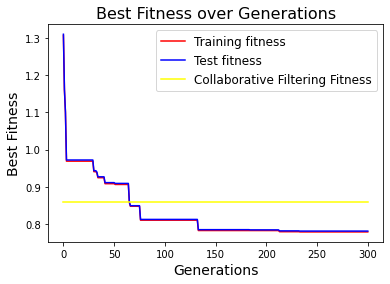

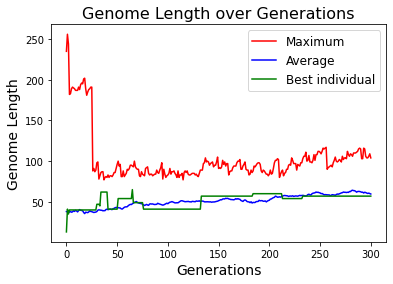

experiment 5
*** splitting data 
train (800167, 20)
test (200042, 20)
*** finished splitting data 
*** grammatical evolution 
* setting up grammar 
* preparing results 
Best individual: 
 add(mul(sub(04.73,x[18]),x[1]),x[6])

Training Fitness:  0.8651915697024253
Test Fitness:  0.8655641536902351
Depth:  6
Length of the genome:  62
Used portion of the genome: 0.18


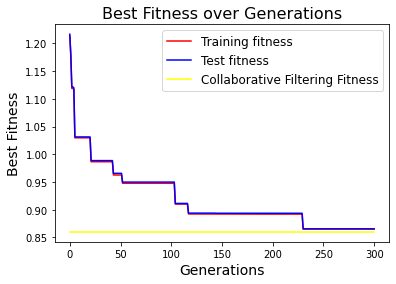

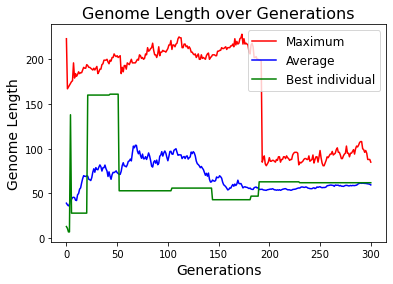

experiment 6
*** splitting data 
train (800167, 20)
test (200042, 20)
*** finished splitting data 
*** grammatical evolution 
* setting up grammar 
* preparing results 
Best individual: 
 add(add(x[16],add(add(x[1],x[12]),add(x[13],x[1]))),x[1])

Training Fitness:  0.7931577860848574
Test Fitness:  0.7919616195790721
Depth:  6
Length of the genome:  17
Used portion of the genome: 0.65


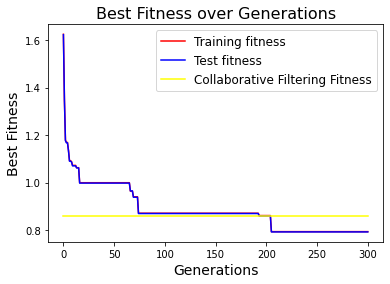

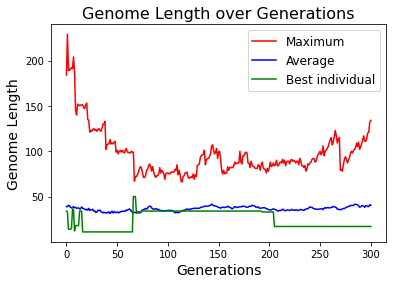

In [ ]:
# results = []
index = 3
for i in range(3): 
    print("experiment " + str(index+i+1))
    data = ratings.copy(deep=True)
    print("*** splitting data ")
    X_train, X_test, Y_train, Y_test = split_data(data)
    print("*** finished splitting data ")
    print("*** grammatical evolution ")
    execute_grammatical_evolution(X_train, X_test, Y_train, Y_test);
    # results.append(experiment_result)

## Experiments 7 - 9

experiment 7
*** splitting data 
train (800167, 20)
test (200042, 20)
*** finished splitting data 
*** grammatical evolution 
* setting up grammar 
* preparing results 
Best individual: 
 add(add(x[11],mul(x[1],04.69)),x[11])

Training Fitness:  0.764595848900638
Test Fitness:  0.7648397883719542
Depth:  6
Length of the genome:  47
Used portion of the genome: 0.23


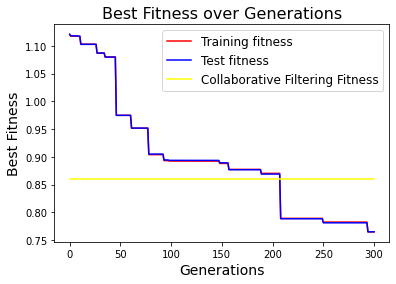

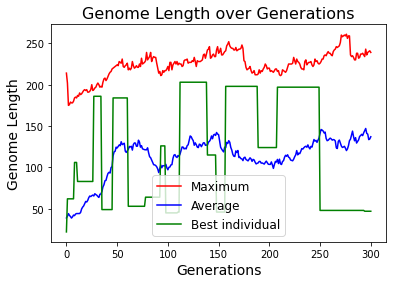

experiment 8
*** splitting data 
train (800167, 20)
test (200042, 20)
*** finished splitting data 
*** grammatical evolution 
* setting up grammar 
* preparing results 
Best individual: 
 add(x[13],sub(mul(x[1],06.10),x[1]))

Training Fitness:  0.7755030859939595
Test Fitness:  0.7732878853006517
Depth:  6
Length of the genome:  149
Used portion of the genome: 0.07


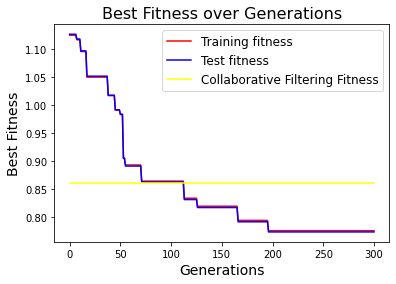

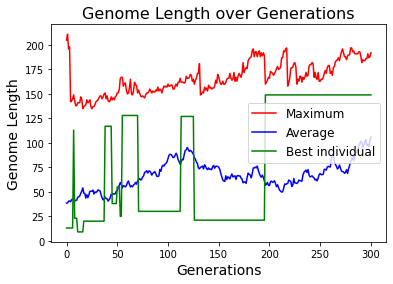

experiment 9
*** splitting data 
train (800167, 20)
test (200042, 20)
*** finished splitting data 
*** grammatical evolution 
* setting up grammar 
* preparing results 
Best individual: 
 add(mul(05.29,x[1]),x[6])

Training Fitness:  0.7801516972217978
Test Fitness:  0.7789124629985822
Depth:  5
Length of the genome:  67
Used portion of the genome: 0.13


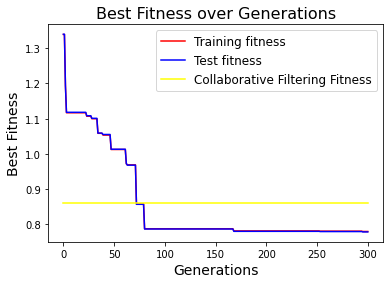

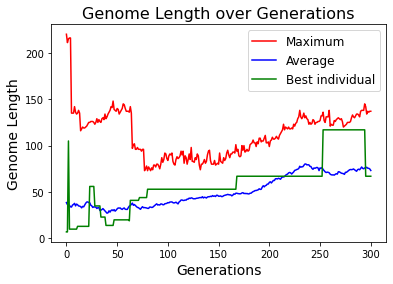

In [ ]:
# results = []
index = 6
for i in range(3): 
    print("experiment " + str(index+i+1))
    data = ratings.copy(deep=True)
    print("*** splitting data ")
    X_train, X_test, Y_train, Y_test = split_data(data)
    print("*** finished splitting data ")
    print("*** grammatical evolution ")
    execute_grammatical_evolution(X_train, X_test, Y_train, Y_test);
    # results.append(experiment_result)

## Experiments 10 - 12

experiment 10
*** splitting data 
train (800167, 20)
test (200042, 20)
*** finished splitting data 
*** grammatical evolution 
* setting up grammar 
* preparing results 
Best individual: 
 add(x[13],mul(x[1],04.92))

Training Fitness:  0.7684400213979756
Test Fitness:  0.7692745150538282
Depth:  5
Length of the genome:  31
Used portion of the genome: 0.29


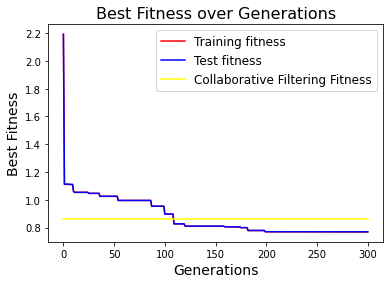

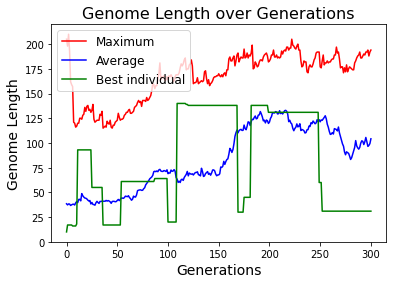

experiment 11
*** splitting data 
train (800167, 20)
test (200042, 20)
*** finished splitting data 
*** grammatical evolution 
* setting up grammar 
* preparing results 
Best individual: 
 add(x[13],mul(x[1],add(x[9],add(04.28,add(sub(x[12],x[1]),x[4])))))

Training Fitness:  0.7879775678460081
Test Fitness:  0.7894060744913005
Depth:  8
Length of the genome:  145
Used portion of the genome: 0.12


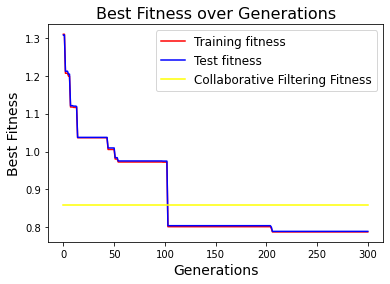

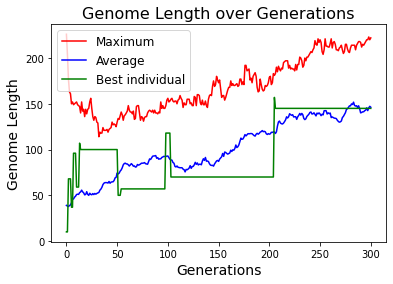

experiment 12
*** splitting data 
train (800167, 20)
test (200042, 20)
*** finished splitting data 
*** grammatical evolution 
* setting up grammar 
* preparing results 
Best individual: 
 add(x[6],mul(x[1],05.35))

Training Fitness:  0.7795443844861216
Test Fitness:  0.7778737322339028
Depth:  5
Length of the genome:  38
Used portion of the genome: 0.24


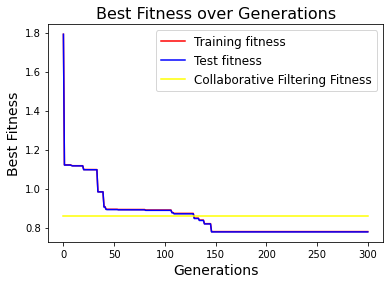

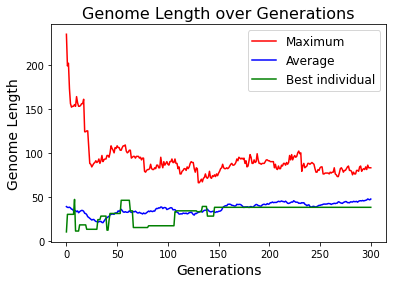

In [ ]:
# results = []
index = 9
for i in range(3): 
    print("experiment " + str(index+i+1))
    data = ratings.copy(deep=True)
    print("*** splitting data ")
    X_train, X_test, Y_train, Y_test = split_data(data)
    print("*** finished splitting data ")
    print("*** grammatical evolution ")
    execute_grammatical_evolution(X_train, X_test, Y_train, Y_test);
    # results.append(experiment_result)

## Experiments 13 -  15

experiment 13
*** splitting data 
train (800167, 20)
test (200042, 20)
*** finished splitting data 
*** grammatical evolution 
* setting up grammar 
* preparing results 
Best individual: 
 add(mul(x[12],x[1]),add(mul(04.46,x[1]),pdiv(x[7],x[7])))

Training Fitness:  0.7476003630509652
Test Fitness:  0.7471947317279435
Depth:  6
Length of the genome:  89
Used portion of the genome: 0.17


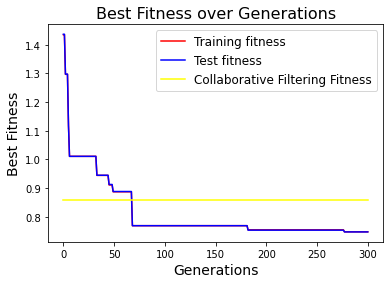

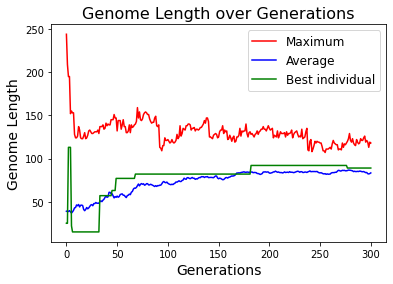

experiment 14
*** splitting data 
train (800167, 20)
test (200042, 20)
*** finished splitting data 
*** grammatical evolution 
* setting up grammar 
* preparing results 
Best individual: 
 add(add(mul(x[2],x[15]),pdiv(x[13],add(x[12],x[9]))),mul(04.59,x[1]))

Training Fitness:  0.7598972276168703
Test Fitness:  0.7602339671192773
Depth:  6
Length of the genome:  40
Used portion of the genome: 0.42


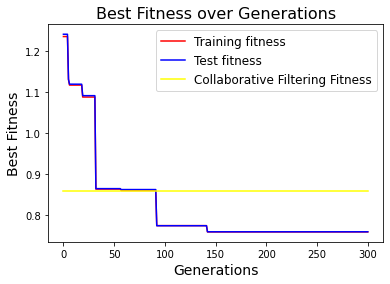

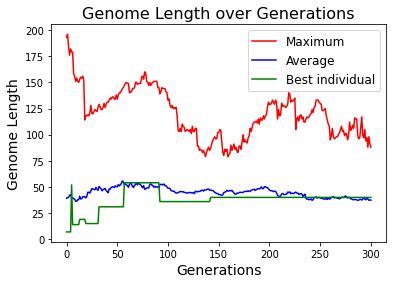

experiment 15
*** splitting data 
train (800167, 20)
test (200042, 20)
*** finished splitting data 
*** grammatical evolution 
* setting up grammar 
* preparing results 
Best individual: 
 add(x[14],mul(x[1],06.60))

Training Fitness:  0.8836076653989375
Test Fitness:  0.8866122205965832
Depth:  5
Length of the genome:  111
Used portion of the genome: 0.08


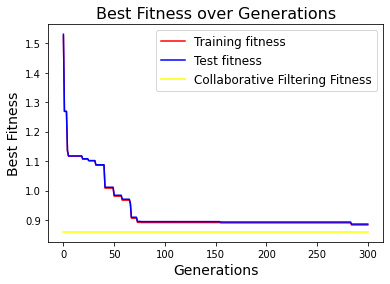

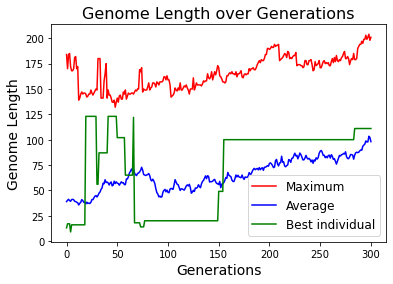

In [ ]:
# results = []
index = 12
for i in range(3): 
    print("experiment " + str(index+i+1))
    data = ratings.copy(deep=True)
    print("*** splitting data ")
    X_train, X_test, Y_train, Y_test = split_data(data)
    print("*** finished splitting data ")
    print("*** grammatical evolution ")
    execute_grammatical_evolution(X_train, X_test, Y_train, Y_test);
    # results.append(experiment_result)

## Experiments 16 - 30

experiment 16
*** splitting data 
train (800167, 20)
test (200042, 20)
*** finished splitting data 
*** grammatical evolution 
* setting up grammar 
* preparing results 
Best individual: 
 add(x[3],add(x[16],add(add(add(x[1],x[1]),x[11]),add(x[11],x[1]))))

Training Fitness:  0.7842560291402663
Test Fitness:  0.7838393490593094
Depth:  7
Length of the genome:  74
Used portion of the genome: 0.18


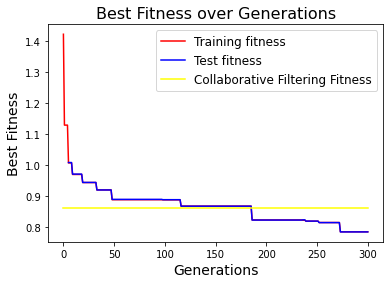

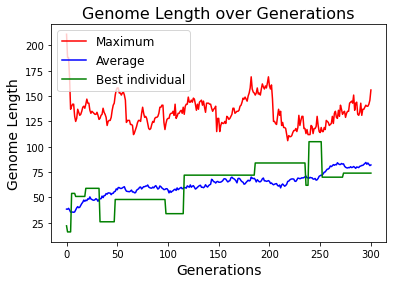

experiment 17
*** splitting data 
train (800167, 20)
test (200042, 20)
*** finished splitting data 
*** grammatical evolution 
* setting up grammar 
* preparing results 
Best individual: 
 add(x[15],mul(x[1],06.38))

Training Fitness:  0.8819663248594368
Test Fitness:  0.8837966947488971
Depth:  5
Length of the genome:  93
Used portion of the genome: 0.10


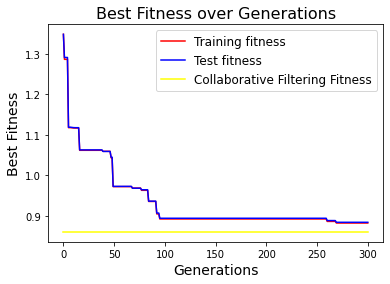

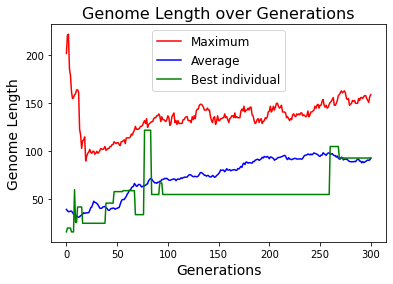

experiment 18
*** splitting data 
train (800167, 20)
test (200042, 20)
*** finished splitting data 
*** grammatical evolution 
* setting up grammar 
* preparing results 
Best individual: 
 add(add(x[16],x[12]),mul(x[1],04.84))

Training Fitness:  0.7690405490067422
Test Fitness:  0.7674138300380317
Depth:  5
Length of the genome:  100
Used portion of the genome: 0.11


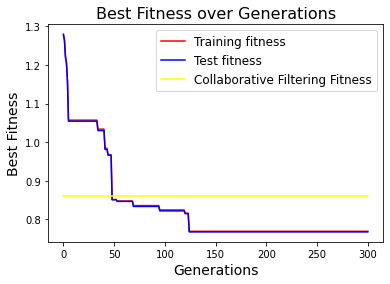

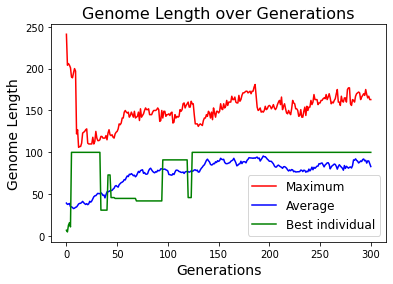

experiment 19
*** splitting data 
train (800167, 20)
test (200042, 20)
*** finished splitting data 
*** grammatical evolution 
* setting up grammar 
* preparing results 
Best individual: 
 add(pdiv(x[1],x[1]),mul(x[1],04.92))

Training Fitness:  0.7461344326168822
Test Fitness:  0.7452177128985061
Depth:  5
Length of the genome:  76
Used portion of the genome: 0.14


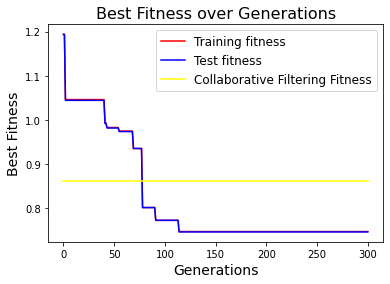

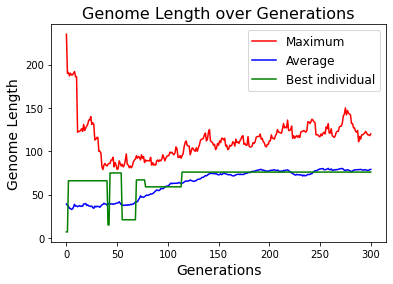

experiment 20
*** splitting data 
train (800167, 20)
test (200042, 20)
*** finished splitting data 
*** grammatical evolution 
* setting up grammar 
* preparing results 
Best individual: 
 add(add(x[12],mul(x[1],05.01)),x[16])

Training Fitness:  0.7784552220753406
Test Fitness:  0.7781183495442545
Depth:  6
Length of the genome:  75
Used portion of the genome: 0.15


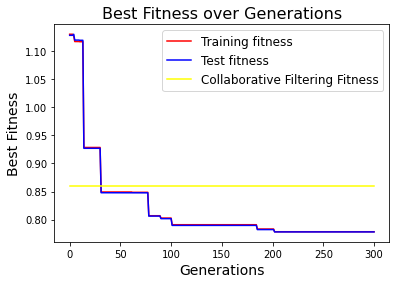

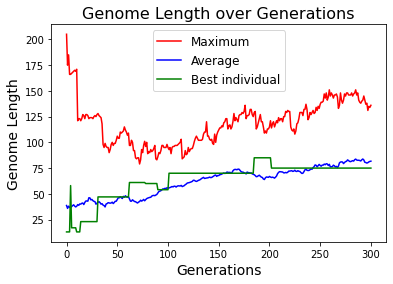

experiment 21
*** splitting data 
train (800167, 20)
test (200042, 20)
*** finished splitting data 
*** grammatical evolution 
* setting up grammar 
* preparing results 
Best individual: 
 add(add(x[12],mul(x[1],04.64)),00.80)

Training Fitness:  0.7426261127138336
Test Fitness:  0.7411910532370476
Depth:  6
Length of the genome:  52
Used portion of the genome: 0.29


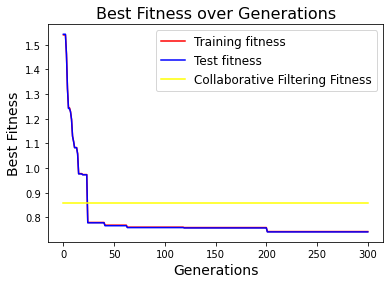

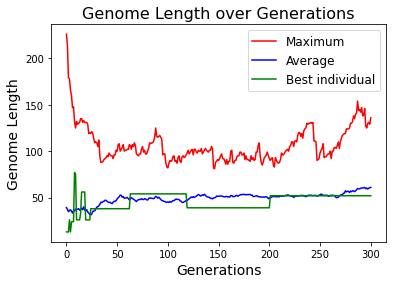

experiment 22
*** splitting data 
train (800167, 20)
test (200042, 20)
*** finished splitting data 
*** grammatical evolution 
* setting up grammar 
* preparing results 
Best individual: 
 add(add(add(mul(04.78,x[1]),x[18]),x[11]),x[11])

Training Fitness:  0.7580688413219149
Test Fitness:  0.7579128110398473
Depth:  7
Length of the genome:  14
Used portion of the genome: 0.93


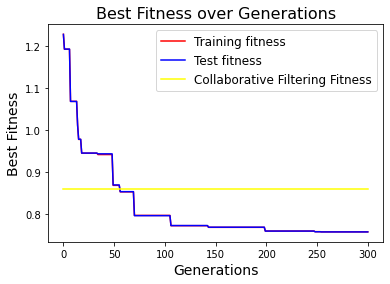

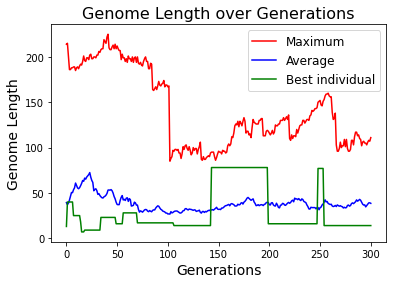

experiment 23
*** splitting data 
train (800167, 20)
test (200042, 20)
*** finished splitting data 
*** grammatical evolution 
* setting up grammar 
* preparing results 
Best individual: 
 add(add(x[6],add(add(x[1],x[3]),add(x[1],x[1]))),x[16])

Training Fitness:  0.7853364720507575
Test Fitness:  0.7860294152617723
Depth:  6
Length of the genome:  68
Used portion of the genome: 0.16


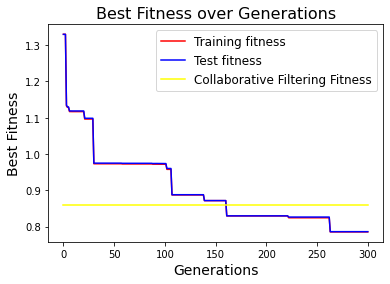

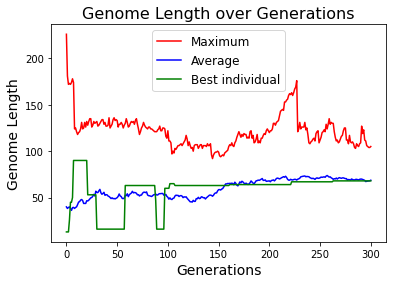

experiment 24
*** splitting data 
train (800167, 20)
test (200042, 20)
*** finished splitting data 
*** grammatical evolution 
* setting up grammar 
* preparing results 
Best individual: 
 add(mul(04.95,x[1]),x[13])

Training Fitness:  0.7687930557677701
Test Fitness:  0.7686795387520131
Depth:  5
Length of the genome:  94
Used portion of the genome: 0.10


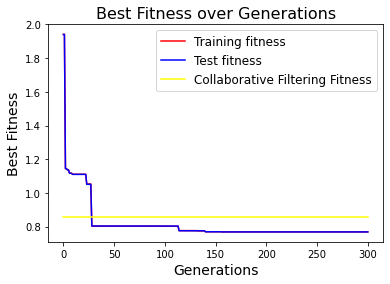

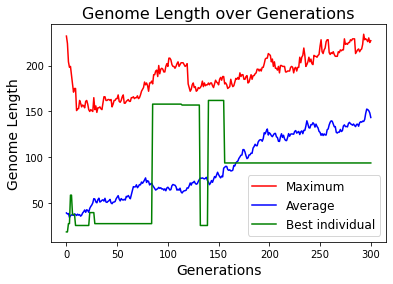

experiment 25
*** splitting data 
train (800167, 20)
test (200042, 20)
*** finished splitting data 
*** grammatical evolution 
* setting up grammar 
* preparing results 
Best individual: 
 add(mul(x[1],04.90),x[13])

Training Fitness:  0.7692394787785988
Test Fitness:  0.7665472458480139
Depth:  5
Length of the genome:  44
Used portion of the genome: 0.20


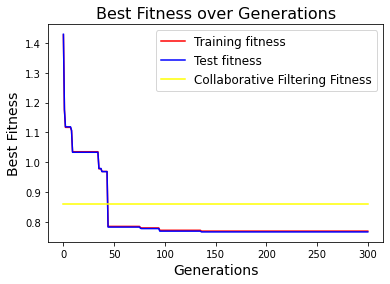

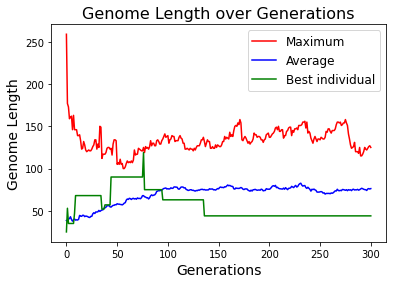

experiment 26
*** splitting data 
train (800167, 20)
test (200042, 20)
*** finished splitting data 
*** grammatical evolution 
* setting up grammar 
* preparing results 
Best individual: 
 add(mul(add(x[16],add(x[6],x[10])),x[1]),add(02.35,x[1]))

Training Fitness:  0.8131260366218875
Test Fitness:  0.8127010663763355
Depth:  6
Length of the genome:  56
Used portion of the genome: 0.27


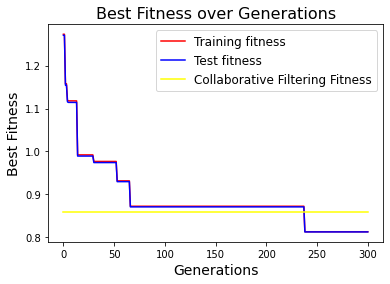

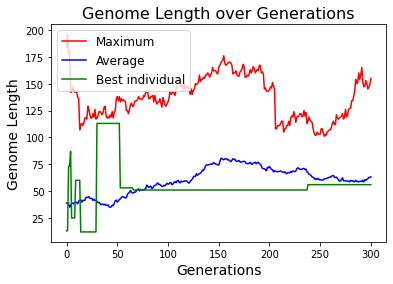

experiment 27
*** splitting data 
train (800167, 20)
test (200042, 20)
*** finished splitting data 
*** grammatical evolution 
* setting up grammar 
* preparing results 
Best individual: 
 add(x[13],mul(x[1],05.00))

Training Fitness:  0.7701336745320578
Test Fitness:  0.7687469241661932
Depth:  5
Length of the genome:  20
Used portion of the genome: 0.45


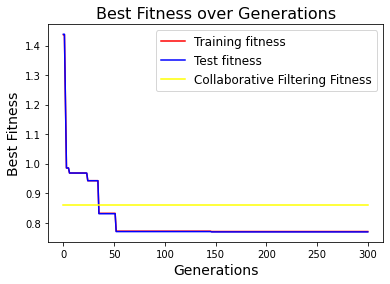

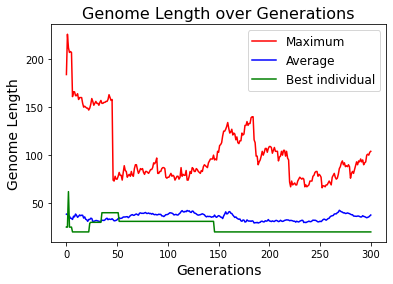

experiment 28
*** splitting data 
train (800167, 20)
test (200042, 20)
*** finished splitting data 
*** grammatical evolution 
* setting up grammar 
* preparing results 
Best individual: 
 add(mul(05.47,x[1]),x[6])

Training Fitness:  0.7823726829191215
Test Fitness:  0.7812978839894201
Depth:  5
Length of the genome:  61
Used portion of the genome: 0.15


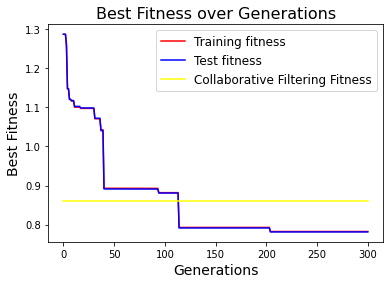

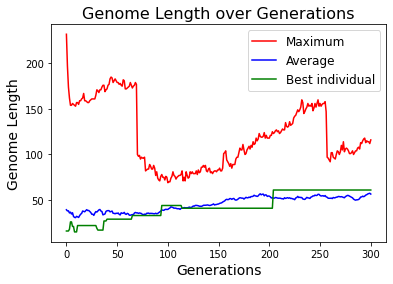

experiment 29
*** splitting data 
train (800167, 20)
test (200042, 20)
*** finished splitting data 
*** grammatical evolution 
* setting up grammar 
* preparing results 
Best individual: 
 add(x[15],mul(06.36,x[1]))

Training Fitness:  0.8821470366913701
Test Fitness:  0.8825981178722526
Depth:  5
Length of the genome:  61
Used portion of the genome: 0.15


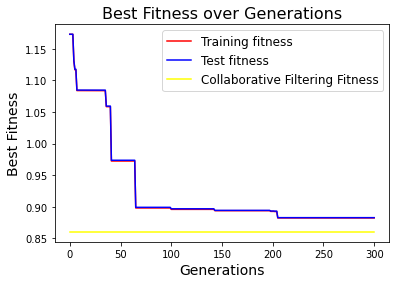

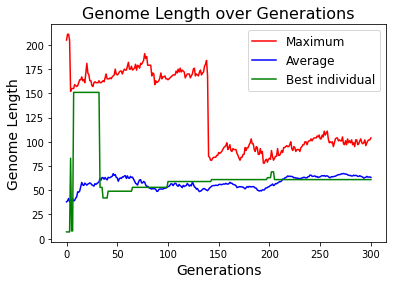

experiment 30
*** splitting data 
train (800167, 20)
test (200042, 20)
*** finished splitting data 
*** grammatical evolution 
* setting up grammar 
* preparing results 
Best individual: 
 add(add(x[1],add(x[1],add(x[13],add(x[12],x[1])))),x[11])

Training Fitness:  0.8210459337842257
Test Fitness:  0.8199891494111545
Depth:  7
Length of the genome:  133
Used portion of the genome: 0.08


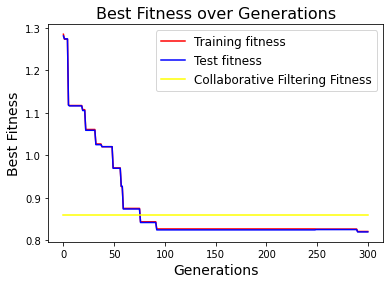

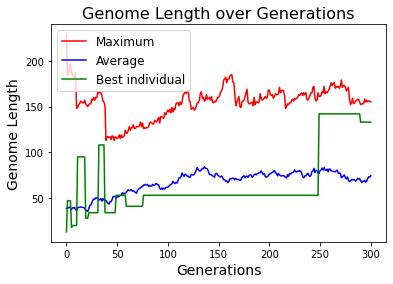

In [ ]:
index = 15
for i in range(15): 
    print("experiment " + str(index+i+1))
    data = ratings.copy(deep=True)
    print("*** splitting data ")
    X_train, X_test, Y_train, Y_test = split_data(data)
    print("*** finished splitting data ")
    print("*** grammatical evolution ")
    execute_grammatical_evolution(X_train, X_test, Y_train, Y_test);
    # results.append(experiment_result)

# Plotting Statistics

## Import Values
I input the values returned at each experiment as python lists 

In [14]:
training_fitness = [
    0.7541071903026031,
    0.8173457007654927,
    0.7730956659214884,
    0.7794593257971675,
    0.8651915697024253,
    0.7931577860848574,
    0.764595848900638,
    0.7755030859939595,
    0.7801516972217978,
    0.7684400213979756,
    0.7879775678460081,
    0.7795443844861216,
    0.7476003630509652,
    0.7598972276168703,
    0.8836076653989375,
    0.7842560291402663,
    0.8819663248594368,
    0.7690405490067422,
    0.7461344326168822,
    0.7784552220753406,
    0.7426261127138336,
    0.7580688413219149,
    0.7853364720507575,
    0.7687930557677701,
    0.7692394787785988,
    0.8131260366218875,
    0.7701336745320578,
    0.7823726829191215,
    0.8821470366913701,
    0.8210459337842257,
]

test_fitness = [
    0.754487240913013,
    0.8136136892586403,
    0.7722151644230701,
    0.7816802031777487,
    0.8655641536902351,
    0.7919616195790721,
    0.7648397883719542,
    0.7732878853006517,
    0.7789124629985822,
    0.7692745150538282,
    0.7894060744913005,
    0.7778737322339028,
    0.7471947317279435,
    0.7602339671192773,
    0.8866122205965832,
    0.7838393490593094,
    0.8837966947488971,
    0.7674138300380317,
    0.7452177128985061,
    0.7781183495442545,
    0.7411910532370476,
    0.7579128110398473,
    0.7860294152617723,
    0.7686795387520131,
    0.7665472458480139,
    0.8127010663763355,
    0.7687469241661932,
    0.7812978839894201,
    0.8825981178722526,
    0.8199891494111545,
]

depth = [7, 7, 6, 5, 6, 6, 6, 6, 5, 5, 8, 5, 6, 6, 5,
         7, 5, 5, 5, 6, 6, 7, 6, 5, 5, 6, 5, 5, 5, 7]

genome_length = [32, 33, 43, 57, 62, 17, 47, 149, 67, 31,
                 145, 38, 89, 40, 111, 74, 93, 100, 76, 75,
                 52, 14, 68, 94, 44, 56, 20, 61, 61, 133]

genome_portion = [0.41, 0.39, 0.30, 0.16, 0.18, 0.65, 0.23, 0.07,
                  0.13, 0.29, 0.12, 0.24, 0.17, 0.42, 0.08, 0.18, 
                  0.10, 0.11, 0.14, 0.15, 0.29, 0.93, 0.16, 0.10,
                  0.20, 0.27, 0.45, 0.15, 0.15, 0.08]

## How do the test and training fitness look over experiments? 

How do they compare to the baseline SVD RMSE score

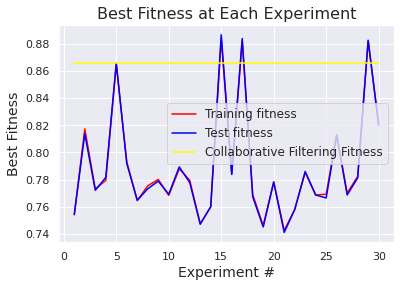

In [16]:
sns.set() 

experiments = []
svd_to_plot = []
svd_rmse = 0.866

for i in range(30): 
    experiments.append(i+1)
    svd_to_plot.append(svd_rmse)
        

plt.plot(experiments, training_fitness, color='red', label="Training fitness")
plt.plot(experiments, test_fitness, color='blue', label="Test fitness")
plt.plot(experiments, svd_to_plot , color='yellow', label="Collaborative Filtering Fitness")
plt.legend(fontsize=12)
plt.xlabel('Experiment #', fontsize=14)
plt.ylabel('Best Fitness', fontsize=14)
plt.title('Best Fitness at Each Experiment', fontsize=16)
plt.show()

Text(0, 0.5, 'Fitness Scores')

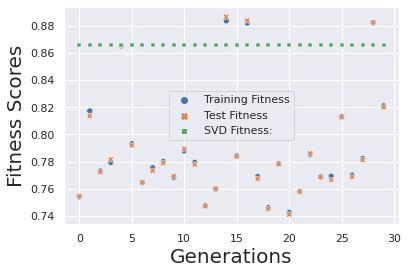

In [9]:
# plotting the training and test fitness again in comparison to SVD 

df = pd.DataFrame({"Training Fitness": training_fitness, 
                   "Test Fitness": test_fitness,
                   "SVD Fitness: " : svd_to_plot})
                  
plot = sns.scatterplot(data=df)
plot.set_xlabel("Generations", fontsize=20)
plot.set_ylabel("Fitness Scores", fontsize= 20)

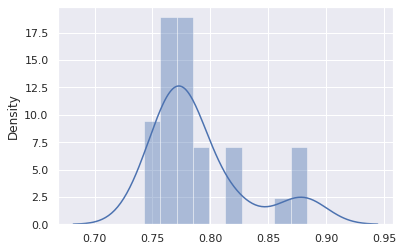

In [26]:
sns.distplot(training_fitness)

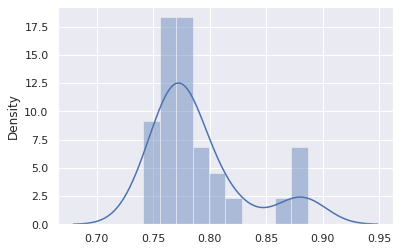

In [27]:
sns.distplot(test_fitness)

## How many experiments performed well?
Counting how many had a lower RMSE than the SVD Collaborative Filtering algorithm

In [32]:
svd_rmse = 0.86 
under_svd_count = 0

for fitness in training_fitness: 
  if (fitness < svd_rmse): 
    under_svd_count += 1 

perc = str(round((under_svd_count/30 * 100),1))
print(str(under_svd_count) + "(" + perc + "%)" + " out of 30 experiments produced a lower training fitness RMSE than the SVD algorithm")

under_svd_count = 0

for fitness in test_fitness: 
  if (fitness < svd_rmse): 
    under_svd_count += 1 

perc = str(round((under_svd_count/30 * 100),1))
print(str(under_svd_count) + "(" + perc + "%)" + " out of 30 experiments produced a lower test fitness RMSE than the SVD algorithm")


26(86.7%) out of 30 experiments produced a lower training fitness RMSE than the SVD algorithm
26(86.7%) out of 30 experiments produced a lower test fitness RMSE than the SVD algorithm


## Calculating Statistical Values

In [34]:
from statistics import mean 
from statistics import stdev 

def print_statistics(collection): 
    avg = sum(collection) / len(collection)
    mn = mean(collection)
    dev = stdev(collection)
    
    print("Average Value: " + str(avg))
    print("Mean Value: " + str(mn))
    print("Standard Deviation: " + str(dev))
    print("Minimum Value: " + str(min(collection)))
    print("Maximum Value: " + str(max(collection)))

### Training Fitness

In [35]:
print_statistics(training_fitness)

Average Value: 0.7894138994455839
Mean Value: 0.7894138994455838
Standard Deviation: 0.04012049348925977
Minimum Value: 0.7426261127138336
Maximum Value: 0.8836076653989375


### Test Fitness

In [36]:
print_statistics(test_fitness)

Average Value: 0.7890412197059616
Mean Value: 0.7890412197059617
Standard Deviation: 0.040682219376586365
Minimum Value: 0.7411910532370476
Maximum Value: 0.8866122205965832


### Depth

Average Value: 5.8
Mean Value: 5.8
Standard Deviation: 0.8469010445797932
Minimum Value: 5
Maximum Value: 8


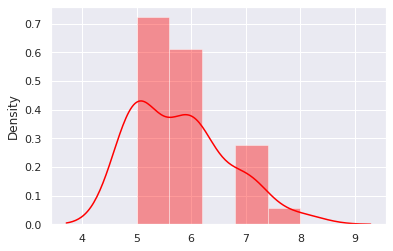

In [37]:
print_statistics(depth)
sns.distplot(depth, color='red', label="Depth")

### Genome Length

Average Value: 66.06666666666666
Mean Value: 66.06666666666666
Standard Deviation: 35.74809696727379
Minimum Value: 14
Maximum Value: 149


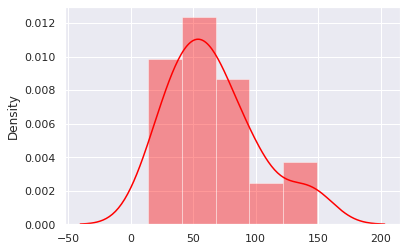

In [38]:
print_statistics(genome_length)
sns.distplot(genome_length, color='red', label="Depth")

### Portion of Genome

Average Value: 0.24333333333333332
Mean Value: 0.24333333333333335
Standard Deviation: 0.1861466484056151
Minimum Value: 0.07
Maximum Value: 0.93


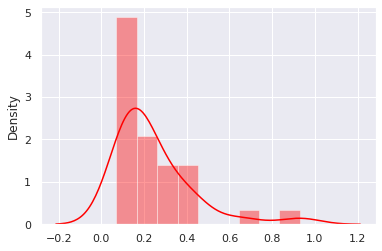

In [39]:
print_statistics(genome_portion)
sns.distplot(genome_portion, color='red', label="Depth")